<a href="https://colab.research.google.com/github/rodrygofesantos/oficina_forped/blob/main/Mapa_de_calor_geo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

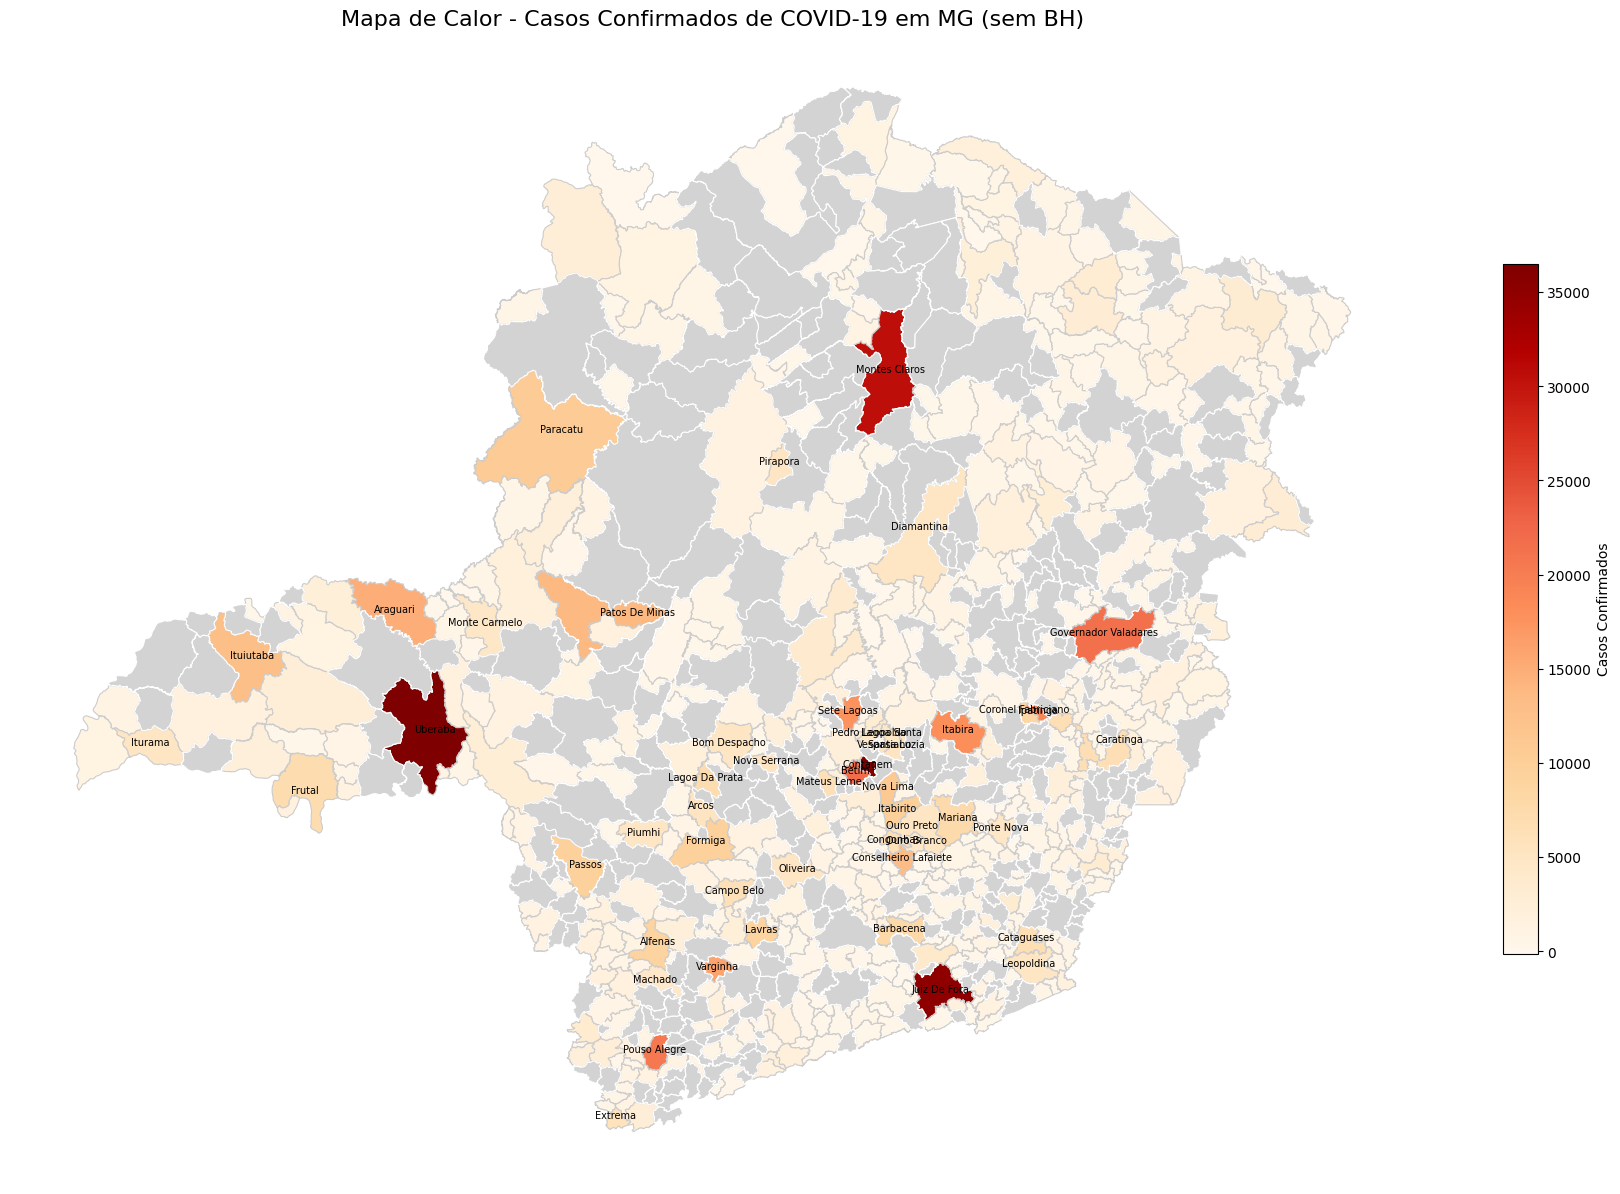

In [15]:
# Bibliotecas necessárias
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Caminhos dos arquivos
csv_path = "/mnt/data/XLSX_Painel_2021.csv"
shp_path = "/mnt/data/MG_Municipios_2024.shp"

# 1. Carrega o shapefile dos municípios de Minas Gerais
gdf = gpd.read_file(shp_path)

# 2. Carrega o CSV com os dados
df = pd.read_csv(csv_path, sep=';', encoding='latin1')

# 3. Padroniza os nomes das colunas
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# 4. Identifica as colunas relevantes
col_municipio = next((c for c in df.columns if 'municip' in c), None)
col_casos = next((c for c in df.columns if 'confirmado' in c), None)

if not col_municipio or not col_casos:
    raise ValueError("Não foi possível identificar as colunas de município ou de casos confirmados.")

# 5. Remove registros nulos e exclui Belo Horizonte
df = df.dropna(subset=[col_municipio, col_casos])
df = df[df[col_municipio].str.upper() != 'BELO HORIZONTE']

# 6. Agrupa os dados por município e soma os casos
df_agg = df.groupby(col_municipio)[col_casos].sum().reset_index()
df_agg.columns = ['municipio', 'casos']
df_agg['municipio'] = df_agg['municipio'].str.upper()

# 7. Padroniza nomes no shapefile e faz o merge com os dados
gdf['NM_MUN'] = gdf['NM_MUN'].str.upper()
gdf = gdf.merge(df_agg, left_on='NM_MUN', right_on='municipio', how='left')

# 8. Gera o mapa com municípios sem dados em cinza
fig, ax = plt.subplots(1, 1, figsize=(18, 12))
gdf.plot(
    column='casos',
    cmap='OrRd',
    linewidth=0.8,
    ax=ax,
    edgecolor='0.8',
    legend=True,
    missing_kwds={
        "color": "lightgray",
        "edgecolor": "white",
        "label": "Sem dados"
    },
    legend_kwds={
        'label': "Casos Confirmados",
        'orientation': "vertical",
        'shrink': 0.6
    }
)

# 9. Rótulos nos municípios com mais casos (top 10%)
for idx, row in gdf.dropna(subset=['casos']).iterrows():
    if row['casos'] > gdf['casos'].quantile(0.9):
        point = row['geometry'].representative_point()
        ax.text(point.x, point.y, row['NM_MUN'].title(), fontsize=7, ha='center', color='black')

# 10. Ajustes finais
ax.set_title("Mapa de Calor - Casos Confirmados de COVID-19 em MG (sem BH)", fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

